In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from haversine import haversine
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
deployments_path = "data/ssusa/ssusa_finaldeployments.csv"
deployments = pd.read_csv(
    deployments_path,
    na_values=["NA", " "],
    dtype={
        "Year": "Int64",
        "Survey_Nights": "float64", 
        "Latitude": "float64",
        "Longitude": "float64",
    },
    keep_default_na=True,
    parse_dates=["Start_Date", "End_Date"]
)

In [3]:
print("Number of deployments:", len(deployments))

Number of deployments: 9679


In [4]:
R = 6371.0088  # Earth's radius in km
max_dist_km = 50
coords_rad = np.radians(deployments[['Latitude', 'Longitude']].values)  # Convert to radians
epsilon = max_dist_km / R  # Convert km to radians

db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
cluster_labels = db.fit(coords_rad).labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords_rad[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))
deployments['Community_ID'] = db.fit_predict(coords_rad)
deployments['Community_ID'].astype('Int64', copy=False, errors='ignore')

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
lats, lons = zip(*centermost_points)
lats = np.degrees(lats)
lons = np.degrees(lons)
centroids = pd.DataFrame({'Latitude_Centroid':lats, 'Longitude_Centroid':lons})
centroids['Community_ID'] = deployments['Community_ID'].unique()

Number of clusters: 167


In [5]:
deployments = deployments.merge(centroids, on='Community_ID', how='left')

In [6]:
print("Number of deployments:", len(deployments))

Number of deployments: 9679


In [7]:
def calculate_distance(row):
    point1 = (row['Latitude'], row['Longitude'])
    point2 = (row['Latitude_Centroid'], row['Longitude_Centroid'])
    return haversine(point1, point2)

deployments['Distance_To_Centroid'] = deployments.apply(calculate_distance, axis=1)

In [8]:
deployments.describe()

,Year,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Community_ID,Latitude_Centroid,Longitude_Centroid,Distance_To_Centroid
count,9679.0,9679,9679,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000
mean,2021.30902,2022-01-03 12:05:07.965699072,2022-02-10 22:13:28.595929600,38.422461,38.784917,-90.847061,57.843992,38.783107,-90.842400,13.737240
min,2019.0,2019-08-17 00:00:00,2019-08-28 00:00:00,1.000000,21.355811,-157.749620,0.000000,21.362700,-157.745090,0.000000
25%,2020.0,2020-09-19 00:00:00,2020-10-26 00:00:00,23.000000,34.999430,-100.241796,23.000000,34.970200,-100.265480,1.172070
50%,2022.0,2022-08-17 00:00:00,2022-09-17 00:00:00,36.000000,39.007630,-85.488724,46.000000,39.004150,-85.485490,4.180283
75%,2023.0,2023-08-15 00:00:00,2023-09-19 00:00:00,53.000000,42.239890,-78.144810,84.000000,42.254880,-78.138550,17.169262
max,2024.0,2023-11-22 00:00:00,2023-12-21 00:00:00,142.000000,59.452635,-68.611593,166.000000,59.414920,-68.625420,146.586506
std,1.401175,NaN,NaN,19.589145,5.729604,16.101408,42.780191,5.727581,16.103583,20.383707


In [9]:
min_lon = deployments['Longitude'].min()
max_lon = deployments['Longitude'].max()
min_lat = deployments['Latitude'].min()
max_lat = deployments['Latitude'].max()

print(f"Longitude range: {min_lon} to {max_lon}")
print(f"Latitude range: {min_lat} to {max_lat}")

Longitude range: -157.74962 to -68.61159314
Latitude range: 21.355811 to 59.452635


In [10]:
num_unique_latlon = deployments[['Latitude', 'Longitude']].drop_duplicates().shape[0]
print(f"Number of unique (latitude, longitude) pairs: {num_unique_latlon}")

Number of unique (latitude, longitude) pairs: 7500


In [11]:
num_unique_centroids = centroids[['Latitude_Centroid', 'Longitude_Centroid']].drop_duplicates().shape[0]
print(f"Number of unique centroids: {num_unique_centroids}")

Number of unique centroids: 167


In [12]:
deployments.to_csv("data/ssusa/ssusa_deployments_with_clusters.csv", index=False)

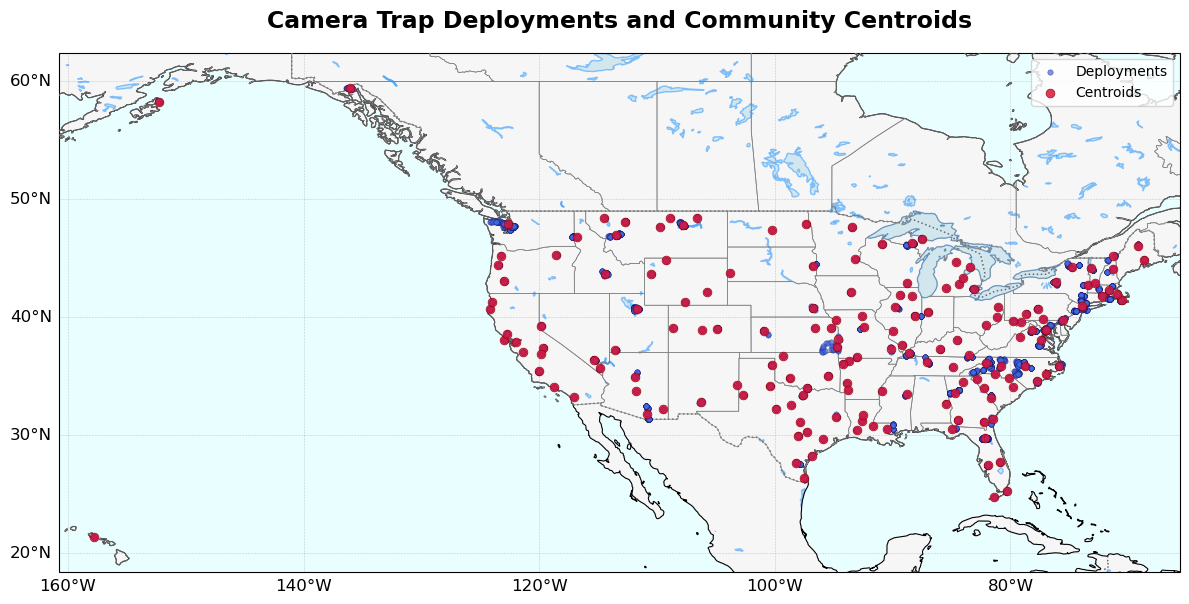

In [13]:
offset = 3
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon - offset, max_lon + offset, min_lat - offset, max_lat + offset], crs=ccrs.PlateCarree())

land = cfeature.NaturalEarthFeature(
    'physical', 'land', '50m', edgecolor='face', facecolor='whitesmoke', alpha=0.9)
ocean = cfeature.NaturalEarthFeature(
    'physical', 'ocean', '50m', edgecolor='none', facecolor='lightcyan', alpha=0.7)
lakes = cfeature.NaturalEarthFeature(
    'physical', 'lakes', '50m', edgecolor='dodgerblue', facecolor='lightblue', alpha=0.5)

ax.add_feature(ocean, zorder=0)
ax.add_feature(land, zorder=1)
ax.add_feature(lakes, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', linewidth=1.1, zorder=3)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=0.8, zorder=3)
ax.add_feature(cfeature.STATES, edgecolor='gray', linestyle='-', linewidth=0.5, zorder=3)

gl = ax.gridlines(
    draw_labels=True, linewidth=0.4, color='gray', alpha=0.4, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'fontsize': 12}
gl.ylabel_style = {'fontsize': 12}

# Plot deployments
ax.scatter(
    deployments['Longitude'], deployments['Latitude'],
    c='royalblue', s=15, alpha=0.7,
    transform=ccrs.PlateCarree(),
    edgecolor='midnightblue', linewidth=0.35, zorder=10,
    label='Deployments'
)

# Plot centroids
ax.scatter(
    centroids['Longitude_Centroid'], centroids['Latitude_Centroid'],
    c='crimson', s=40, alpha=0.85,
    transform=ccrs.PlateCarree(),
    edgecolor='darkred', linewidth=0.5, zorder=11,
    label='Centroids'
)

plt.title(
    'Camera Trap Deployments and Community Centroids',
    fontsize=17, fontweight='bold', pad=18
)
plt.legend(loc='best')
plt.tight_layout()
plt.show()